In [1]:
import os, sys

import sgpp, sgml, dproc, sgutil
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(sys.version)

from sklearn.pipeline import make_pipeline

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]


In [2]:
sc = sgutil.SGCache('img', 'result', 'model')
p = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.ExprProcessor({
        'ELm_num': (pl.col('Episode_Length_minutes').clip(5, 120) - 5) / 115,
        'GP': (pl.col('Guest_Popularity_percentage').fill_null(pl.col('Guest_Popularity_percentage').clip(0,100).mean()).clip(0, 100) / 100),
        'HP': pl.col('Host_Popularity_percentage').clip(0, 100) / 100,
        'NAd': (pl.when(pl.col('Number_of_Ads') > 4).then(0).otherwise(pl.col('Number_of_Ads'))).fill_null(0.0) /3 ,
        'Number_of_Ads': (pl.when(pl.col('Number_of_Ads') > 4).then(0).otherwise(pl.col('Number_of_Ads'))).fill_null(0).cast(pl.Int8),
        'ELm_na': pl.col('Episode_Length_minutes').is_null(),
        'GPp_na': pl.col('Guest_Popularity_percentage').is_null(),
        'ELm_sqrt': ((pl.col('Episode_Length_minutes').clip(5, 120) - 5) / 115)  ** 0.5
    }),
    sgpp.PandasConverter(index_col = 'id')
)
p.fit(['data/train.csv'])
df_train = p.transform(['data/train.csv'])
df_test = p.transform(['data/test.csv'])
target = 'Listening_Time_minutes'
X_all = [i for i in df_train.columns if i != target]

In [3]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold, cross_validate, cross_val_score, ShuffleSplit
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector
kf = KFold(5, shuffle = True, random_state = 123)
ss = ShuffleSplit(1, train_size = 0.8, random_state = 123)
target = 'Listening_Time_minutes'
X_all = [i for i in df_train.columns if i != target]

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index),
    'score_func': lambda df, prds: root_mean_squared_error(df[target], prds),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': target,
}

lr_adapter = sgml.SklearnAdapter(LinearRegression)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMRegressor, progress = 50)
xgb_adapter = sgml.XGBAdapter(xgb.XGBRegressor, progress = 50)

In [4]:
from sklearn.model_selection import train_test_split
df_train_1, df_test_1 = train_test_split(df_train, train_size = 0.75, random_state = 123, shuffle = True)

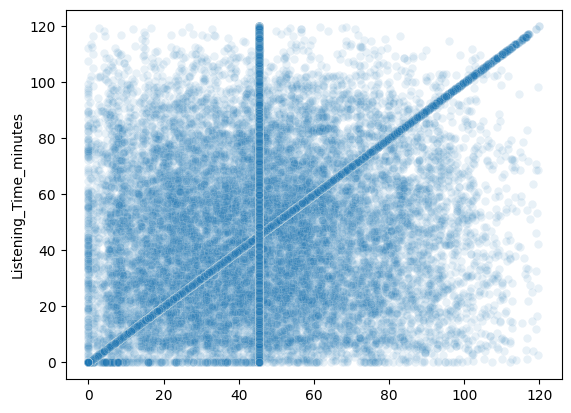

In [5]:
from sklearn.preprocessing import TargetEncoder
tge = TargetEncoder()
sns.scatterplot(
    x = tge.fit_transform(
        df_train_1[['Episode_Title', 'Host_Popularity_percentage', 'Guest_Popularity_percentage']].astype('str').sum(axis = 1).rename('c').to_frame(), 
        df_train_1[target]
    )[:, 0],
    y = df_train_1[target], alpha = 0.1
)
plt.show()

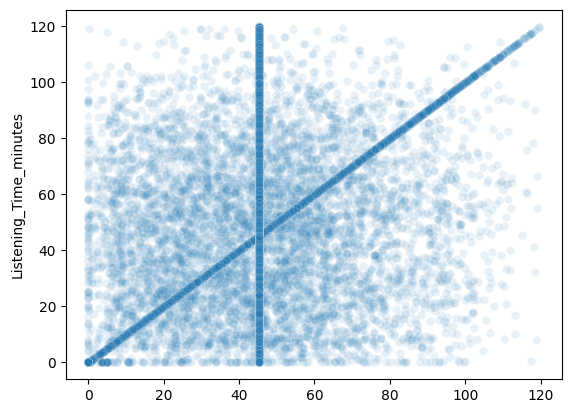

In [6]:
y_prd = tge.transform(
    df_test_1[['Episode_Title', 'Host_Popularity_percentage', 'Guest_Popularity_percentage']].astype('str').sum(axis = 1).astype('category').rename('c').to_frame()
)[:, 0]
sns.scatterplot(
    x = y_prd,
    y = df_test_1[target], alpha = 0.1
)
plt.show()

In [7]:
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(
    df_test_1[target],
    tge.transform(
        df_test_1[['Episode_Title', 'Host_Popularity_percentage', 'Guest_Popularity_percentage']].astype('str').sum(axis = 1).astype('category').rename('c').to_frame()
    )
)

np.float64(27.036024754823252)

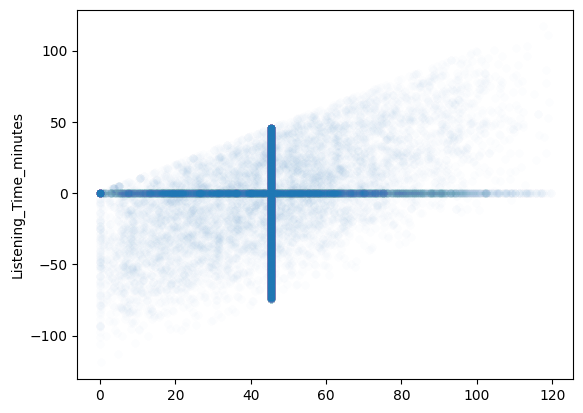

In [8]:
sns.scatterplot(
    x = y_prd,
    y = (y_prd - df_test_1[target]), alpha = 0.01
)
plt.show()

In [9]:
s_stat = df_train.groupby(['Episode_Title', 'Host_Popularity_percentage', 'Guest_Popularity_percentage'], observed = True)[target].agg(
    ['mean', 'std', 'count']
)
s_stat

mean  \
Episode_Title Host_Popularity_percentage Guest_Popularity_percentage               
Episode 98    20.010000                  67.919998                     32.032829   
              20.100000                  93.949997                     97.953247   
              20.160000                  23.100000                      8.782320   
              20.180000                  61.820000                     68.136902   
              20.200001                  85.330002                     47.428131   
...                                                                          ...   
Episode 70    99.930000                  4.780000                       6.323140   
                                         99.099998                     73.393478   
              99.989998                  2.170000                      10.917020   
              117.139999                 71.480003                    109.621948   
                                         71.519997                    109.621948   

                                                                      std  \
Episode_Title Host_Popularity_percentage Guest_Popularity_percentage        
Episode 98    20.010000                  67.919998                    NaN   
              20.100000                  93.949997                    NaN   
              20.160000                  23.100000                    NaN   
              20.180000                  61.820000                    NaN   
              20.200001                  85.330002                    NaN   
...                                                                   ...   
Episode 70    99.930000                  4.780000                     NaN   
                                         99.099998                    NaN   
              99.989998                  2.170000                     NaN   
              117.139999                 71.480003                    NaN   
                                         71.519997                    NaN   

                                                                      count  
Episode_Title Host_Popularity_percentage Guest_Popularity_percentage         
Episode 98    20.010000                  67.919998                        1  
              20.100000                  93.949997                        1  
              20.160000                  23.100000                        1  
              20.180000                  61.820000                        1  
              20.200001                  85.330002                        1  
...                                                                     ...  
Episode 70    99.930000                  4.780000                         1  
                                         99.099998                        1  
              99.989998                  2.170000                         1  
              117.139999                 71.480003                        1  
                                         71.519997                        1  

[589534 rows x 3 columns]

In [ ]:
pd.

In [25]:
from sklearn.base import TransformerMixin
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
class TargetEncoder2(TransformerMixin):
    def __init__(self, vals, max_std= 1, min_count = 2, cv = KFold(5, shuffle = True, random_state = 123)):
        self.vals = vals
        self.max_std = max_std
        self.min_count = min_count
        self.cv = cv
        
    def fit(self, X, y = None):
        self.stat_ = [
            (val, X.assign(target = y).groupby(val, observed = True)['target'].agg(
                ['mean', 'std', 'count']
            ).pipe(
                lambda x: x.loc[(x['std'] <= self.max_std) & (x['count'] >= self.min_count)]
            )['mean'].copy())
            for val in self.vals
        ]
        self.fitted_ = True
        return self

    def transform(self, X, **argv):
        return pd.concat([
            #X.groupby(val).apply(lambda x: pd.Series(stat.get(x.name, np.nan), index = x.index))
            X[val].apply(tuple, axis=1).map(stat).rename('__'.join(val)) if len(val) > 1 else X[val[0]].map(stat).rename(val[0])
            for val, stat in self.stat_
        ], axis=1)
        
    def fit_transform(self, X, y = None):
        ret = list()
        for train_idx, valid_idx in self.cv.split(X, y):
            self.fit(X.iloc[train_idx], y.iloc[train_idx])
            ret.append(self.transform(X.iloc[valid_idx]))
            print('.')
        return pd.concat(ret).loc[X.index]
            
    def get_params(self, deep=True):
        return {
            "vals": self.vals, 
            "max_std": self.max_std,
            "min_count": self.min_count,
        }

    def set_output(self, transform='pandas'):
        pass

    def get_feature_names_out(self, X = None):
        return ['__'.join(val) for val, _ in self.vals]

In [11]:
from itertools import combinations
X_var = [
    'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes', 'Genre', 'Host_Popularity_percentage',
    'Publication_Day', 'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment'
]
X_inter1 = [list(i) for i in combinations(X_var, 1)]
X_inter2 = [list(i) for i in combinations(X_var, 2)]
X_inter3 = [list(i) for i in combinations(X_var, 3)]
X_inter4 = [list(i) for i in combinations(X_var, 4)]
len(X_inter1 + X_inter2 + X_inter3 + X_inter4)
X_tgt_sel = X_inter1 + X_inter2 + X_inter3 + X_inter4 
len(X_tgt_sel)

385

In [27]:
len(X_var)

10

In [29]:
n = 0
for i in range(1, len(X_var)):
    n += len(list(combinations(X_var, i)))
n

1022

In [23]:
X_tgt_sel = ['Episode_Length_minutes',
  'Episode_Length_minutes,Number_of_Ads',
  'Episode_Length_minutes,Episode_Sentiment',
  'Episode_Length_minutes,Publication_Time',
  'Episode_Length_minutes,Publication_Day',
  'Episode_Length_minutes,Genre',
  'Episode_Length_minutes,Number_of_Ads,Episode_Sentiment',
  'Episode_Length_minutes,Episode_Sentiment,Publication_Time',
  'Episode_Length_minutes,Number_of_Ads,Publication_Time',
  'Episode_Length_minutes,Episode_Sentiment,Publication_Day',
  'Episode_Length_minutes,Number_of_Ads,Publication_Day',
  'Episode_Length_minutes,Publication_Time,Publication_Day',
  'Episode_Length_minutes,Episode_Sentiment,Genre',
  'Episode_Length_minutes,Number_of_Ads,Genre',
  'Episode_Length_minutes,Publication_Time,Genre',
  'Episode_Length_minutes,Podcast_Name',
  'Episode_Length_minutes,Publication_Day,Genre',
  'Episode_Length_minutes,Episode_Title',
  'Episode_Length_minutes,Episode_Sentiment,Podcast_Name',
  'Episode_Length_minutes,Number_of_Ads,Podcast_Name',
  'Episode_Length_minutes,Publication_Time,Podcast_Name',
  'Episode_Length_minutes,Episode_Sentiment,Episode_Title',
  'Episode_Length_minutes,Number_of_Ads,Episode_Title',
  'Episode_Length_minutes,Publication_Time,Episode_Title',
  'Episode_Length_minutes,Guest_Popularity_percentage',
  'Episode_Length_minutes,Publication_Day,Podcast_Name',
  'Episode_Length_minutes,Episode_Sentiment,Guest_Popularity_percentage',
  'Episode_Length_minutes,Number_of_Ads,Guest_Popularity_percentage',
  'Episode_Length_minutes,Publication_Day,Episode_Title',
  'Episode_Length_minutes,Publication_Time,Guest_Popularity_percentage',
  'Episode_Length_minutes,Publication_Day,Guest_Popularity_percentage',
  'Episode_Length_minutes,Genre,Episode_Title',
  'Episode_Length_minutes,Genre,Guest_Popularity_percentage',
  'Episode_Length_minutes,Host_Popularity_percentage',
  'Episode_Length_minutes,Podcast_Name,Episode_Title',
  'Episode_Length_minutes,Podcast_Name,Guest_Popularity_percentage',
  'Episode_Length_minutes,Episode_Title,Guest_Popularity_percentage',
  'Episode_Length_minutes,Episode_Sentiment,Host_Popularity_percentage',
  'Episode_Length_minutes,Number_of_Ads,Host_Popularity_percentage',
  'Episode_Length_minutes,Publication_Time,Host_Popularity_percentage',
  'Episode_Length_minutes,Episode_Title,Host_Popularity_percentage',
  'Host_Popularity_percentage,Guest_Popularity_percentage',
  'Podcast_Name,Episode_Title,Host_Popularity_percentage',
  'Episode_Length_minutes,Podcast_Name,Host_Popularity_percentage',
  'Episode_Length_minutes,Publication_Day,Host_Popularity_percentage',
  'Episode_Length_minutes,Guest_Popularity_percentage,Host_Popularity_percentage',
  'Number_of_Ads,Episode_Sentiment,Episode_Title',
  'Podcast_Name,Episode_Title,Guest_Popularity_percentage',
  'Number_of_Ads,Episode_Title',
  'Number_of_Ads,Publication_Time,Episode_Title',
  'Number_of_Ads,Episode_Sentiment,Podcast_Name',
  'Number_of_Ads,Publication_Day,Episode_Title',
  'Number_of_Ads,Podcast_Name',
  'Number_of_Ads,Publication_Time,Podcast_Name',
  'Host_Popularity_percentage',
  'Number_of_Ads,Publication_Day,Podcast_Name',
  'Number_of_Ads,Episode_Sentiment,Genre',
  'Number_of_Ads,Episode_Sentiment,Publication_Time',
  'Number_of_Ads,Episode_Sentiment,Publication_Day',
  'Number_of_Ads,Publication_Day,Genre',
  'Number_of_Ads,Publication_Time,Genre',
  'Number_of_Ads,Episode_Sentiment',
  'Number_of_Ads,Publication_Time,Publication_Day',
  'Number_of_Ads,Publication_Day',
  'Number_of_Ads',
  'Episode_Sentiment,Guest_Popularity_percentage,Host_Popularity_percentage',
  'Episode_Sentiment,Episode_Title',
  'Episode_Sentiment,Publication_Day,Episode_Title',
  'Guest_Popularity_percentage',
  'Episode_Title',
  'Episode_Sentiment,Genre,Episode_Title',
  'Host_Popularity_percentage,Number_of_Ads',
  'Number_of_Ads,Guest_Popularity_percentage,Host_Popularity_percentage',
  'Episode_Sentiment,Publication_Day,Podcast_Name',
  'Episode_Sentiment,Podcast_Name',
  'Genre,Podcast_Name,Episode_Title',
  'Episode_Title,Podcast_Name',
  'Publication_Time,Publication_Day,Podcast_Name',
  'Episode_Sentiment,Publication_Day',
  'Genre,Publication_Day',
  'Number_of_Ads,Podcast_Name,Episode_Title',
  'Publication_Time,Guest_Popularity_percentage,Host_Popularity_percentage',
  'Genre',
  'Host_Popularity_percentage,Episode_Sentiment',
  'Publication_Day,Genre,Episode_Title',
  'Genre,Episode_Title,Guest_Popularity_percentage',
  'Publication_Day,Episode_Title,Guest_Popularity_percentage',
  'Episode_Sentiment,Podcast_Name,Episode_Title',
  'Host_Popularity_percentage,Publication_Time',
  'Publication_Time,Podcast_Name,Episode_Title',
  'Guest_Popularity_percentage,Number_of_Ads',
  'Guest_Popularity_percentage,Episode_Sentiment',
  'Podcast_Name,Guest_Popularity_percentage,Host_Popularity_percentage',
  'Publication_Day,Guest_Popularity_percentage,Host_Popularity_percentage',
  'Genre,Episode_Title,Host_Popularity_percentage',
  'Guest_Popularity_percentage,Publication_Time',
  'Number_of_Ads,Episode_Title,Guest_Popularity_percentage',
  'Publication_Day,Podcast_Name,Episode_Title',
  'Publication_Day,Episode_Title,Host_Popularity_percentage',
  'Genre,Guest_Popularity_percentage,Host_Popularity_percentage',
  'Publication_Time,Episode_Title,Guest_Popularity_percentage',
  'Host_Popularity_percentage,Publication_Day',
  'Episode_Sentiment,Episode_Title,Guest_Popularity_percentage',
  'Publication_Day,Podcast_Name,Guest_Popularity_percentage',
  'Guest_Popularity_percentage,Publication_Day',
  'Number_of_Ads,Episode_Sentiment,Host_Popularity_percentage',
  'Host_Popularity_percentage,Genre',
  'Number_of_Ads,Episode_Title,Host_Popularity_percentage',
  'Publication_Time,Episode_Title,Host_Popularity_percentage',
  'Episode_Sentiment,Publication_Time,Host_Popularity_percentage',
  'Number_of_Ads,Episode_Sentiment,Guest_Popularity_percentage',
  'Guest_Popularity_percentage,Genre',
  'Number_of_Ads,Publication_Time,Host_Popularity_percentage',
  'Number_of_Ads,Podcast_Name,Guest_Popularity_percentage',
  'Publication_Time,Podcast_Name,Guest_Popularity_percentage',
  'Episode_Sentiment,Episode_Title,Host_Popularity_percentage',
  'Episode_Sentiment,Publication_Time,Guest_Popularity_percentage',
  'Publication_Day,Podcast_Name,Host_Popularity_percentage',
  'Episode_Sentiment,Podcast_Name,Guest_Popularity_percentage',
  'Guest_Popularity_percentage,Episode_Title',
  'Episode_Sentiment,Publication_Day,Guest_Popularity_percentage',
  'Number_of_Ads,Publication_Day,Guest_Popularity_percentage',
  'Number_of_Ads,Podcast_Name,Host_Popularity_percentage',
  'Publication_Time,Podcast_Name,Host_Popularity_percentage',
  'Number_of_Ads,Publication_Day,Host_Popularity_percentage',
  'Publication_Time,Publication_Day,Guest_Popularity_percentage',
  'Publication_Time,Publication_Day,Host_Popularity_percentage',
  'Episode_Sentiment,Genre,Guest_Popularity_percentage',
  'Publication_Day,Genre,Guest_Popularity_percentage',
  'Episode_Sentiment,Genre,Host_Popularity_percentage',
  'Guest_Popularity_percentage,Podcast_Name',
  'Host_Popularity_percentage,Episode_Title',
  'Publication_Time,Genre,Host_Popularity_percentage']
X_tgt_sel = [i.split(',') for i in X_tgt_sel]
len(X_tgt_sel)

133

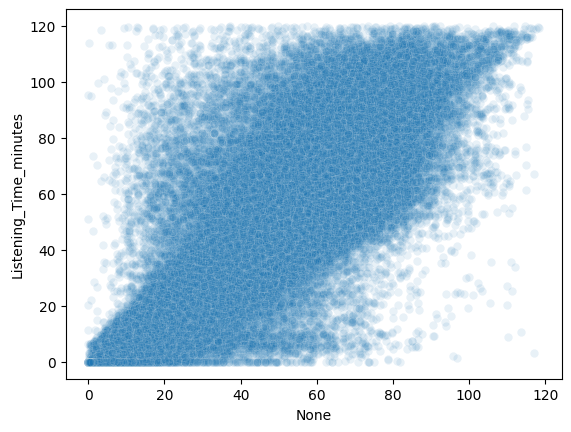

In [39]:
tge2 = TargetEncoder2(X_tgt_sel, max_std = 15, min_count = 3)
y_prd_tgt_train = tge2.fit_transform(df_train_1, df_train_1[target])
y_prd_tgt = tge2.transform(df_test_1)
y_prd = y_prd_tgt.mean(axis=1)
sns.scatterplot(
    x = y_prd, y = df_test_1[target], alpha = 0.1
)
plt.show()

In [187]:
y_prd_tgt_train.iloc[:, :].mean(axis=1).pipe(
    lambda x: root_mean_squared_error(
        df_train_1.loc[x.notna(), target], x.dropna()
    )
)

15.435508176648465

In [40]:
df_train_2 = dproc.join_and_assign(df_train_1, y_prd_tgt_train)
df_test2 = dproc.join_and_assign(df_test_1, y_prd_tgt)

In [41]:
hparams = {
    'model_params': {'num_leaves': 1024, 'n_estimators': 1500, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'metric': 'rmse'},
    'X_num': ['GP', 'HP', 'NAd', 'ELm_num', 'ELm_na'] + ['__'.join(i) for i in X_tgt_sel],
    'validation_fraction': 0.1
}
result = sgml.train(df_train_2, hparams, config, lgb_adapter)

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

In [42]:
predictor = sgml.assemble_predictor(result[0]['model'], None, result[0]['variables'], config)
root_mean_squared_error(
    df_test2[target], predictor(df_test2)
)

12.686387826372453

In [188]:
y_prd_tgt.iloc[:, :].mean(axis=1).pipe(
    lambda x: root_mean_squared_error(
        df_test_1.loc[x.notna(), target], x.dropna()
    )
)

15.444107641020263

In [184]:
y_prd_tgt.iloc[:, :].mean(axis=1).isna().mean()

0.011552

In [200]:
X_notna = y_prd_tgt_train.columns[y_prd_tgt_train.isna().mean() < 1].tolist()

In [201]:
from sklearn.linear_model import LinearRegression

reg_lr = LinearRegression()
reg_lr.fit(y_prd_tgt_train.fillna(y_prd_tgt_train.mean())[X_notna], df_train_1[target])

LinearRegression()

In [204]:
root_mean_squared_error(
    df_test_1[target],
    reg_lr.predict(y_prd_tgt.fillna(y_prd_tgt_train.mean())[X_notna])
)

16.3510684967041

In [205]:
root_mean_squared_error(
    df_train_1[target],
    reg_lr.predict(y_prd_tgt_train.fillna(y_prd_tgt_train.mean())[X_notna])
)

16.388700485229492